To use this notebook, first execute the first cells to install packages, set a working directory, and create the functions for analyzing data.

There are 3 types of files - emission data, background data, and black body calibration. The background data is a blank data set using water or buffer that is subtracted from the emission data. This removes effects of extraneous light, which should be negligible compared to a strong enough signal. The black body calibration is a relative multiplier for each wavelength, which calibrates the system to account for differences in sensitivity across wavelengths.

Background and calibration files are usually the same across samples for an entire session, so these can be set once early.

# Cells to execute first before data analysis

In [1]:
#Packages necessaryt for running functions. Directed to null to not print
%pip install pandas matplotlib numpy scipy Pyarrow!pip install some-package > /dev/null 2>&1

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Set working directory to data directory
%cd /Users/oakley/Documents/GitHub/EmissionSpectra/data/June1-2023-Panama_Purple

#set background and calibration files for this session

background='June1-water-background.asc'
calibration='PL correction factor 053123.txt'

/Users/oakley/Documents/GitHub/EmissionSpectra/data/June1-2023-Panama_Purple


In [19]:
#Functions for analyzing emission spectra

import numpy as np
from scipy.signal import savgol_filter
import pandas as pd
import matplotlib.pyplot as plt

#*****Employ Sovitzky-Golay smoothing 

def sgMaxPlot(df, polyorder=2, window_length=11, xmin=400, xmax=650):
    # Ensure window_length is odd and greater than polyorder
    if window_length % 2 == 0:
        window_length += 1  # Increase window_length by 1 if it's not odd
    
    # Apply Savitzky-Golay smoothing on the 'calibrated_emission' column
    sgdf = savgol_filter(df['calibrated_emission'], window_length, polyorder)
    
    # Normalize the smoothed data so the max value is 1
    sgdf_normalized = sgdf / sgdf.max()
    
    # Plot normalized smoothed data in blue
    plt.plot(df['wavelength'], sgdf_normalized, label='Normalized Smoothed Data', color='blue')
    
    # Find the wavelength corresponding to the max value in the normalized smoothed data
    max_index = sgdf_normalized.argmax()
    max_wavelength = df['wavelength'].iloc[max_index]
    
    # Draw a vertical line at the wavelength of the max value in the normalized smoothed data
    plt.axvline(x=max_wavelength, color='red', linestyle='--', label=f'Max at {max_wavelength}nm')
    
    # Set the axis labels
    plt.xlabel('Wavelength')
    plt.ylabel('Normalized Emission')
    
    # Set the x-axis limits
    plt.xlim(xmin, xmax)
    
    # Add a legend
    plt.legend()
    
    # Display the plot
    plt.show()
    
    # Calculate FWHM
    half_max = 0.5
    # Indices where data crosses the half maximum
    cross_half_max_indices = np.where(np.diff(np.sign(sgdf_normalized - half_max)))[0]
    # Ensure we find the points surrounding the max value
    left_index = cross_half_max_indices[cross_half_max_indices < max_index][-1]
    right_index = cross_half_max_indices[cross_half_max_indices > max_index][0]
    # Calculate FWHM
    fwhm = df['wavelength'].iloc[right_index] - df['wavelength'].iloc[left_index]
    
    return max_wavelength, fwhm

#*****Function to subtract background and calibrate

def formatEmission(emissionFile, backgroundFile, fcol, lcol, calibrationFile, plot=True, verbose=False):
    # Read the emission data file with all columns
    emissionData = pd.read_csv(emissionFile, header=None, sep=',')
    emission_columns = ['wavelength'] + [f'sample{i}' for i in range(1, len(emissionData.columns))]
    emissionData.columns = emission_columns
    if verbose:
        print("Emission Data Loaded:\n", emissionData.head())

    # Plot each emission column if verbose is True
    if plot and verbose:
        plt.figure(figsize=(10, 6))
        for i in range(fcol, lcol + 1):  # Adjusted to use fcol and lcol for range
            max_value = emissionData.iloc[:, i].max()
            plt.plot(emissionData['wavelength'], emissionData.iloc[:, i], label=f'Sample {i - 1} (Max: {max_value:.2f})')
        plt.xlabel('Wavelength')
        plt.ylabel('Emission')
        plt.title('Emission Data')
        plt.legend()
        plt.show()

    # Read the background data file with all columns
    backgroundData = pd.read_csv(backgroundFile, header=None, sep=',')
    background_columns = ['wavelength'] + [f'background{i}' for i in range(1, len(backgroundData.columns))]
    backgroundData.columns = background_columns
    if verbose:
        print("Background Data Loaded:\n", backgroundData.head())

    # Read the calibration data file
    calibrationData = pd.read_csv(calibrationFile, sep='\t', header=None, names=['wavelength', 'calibration'])
    if verbose:
        print("Calibration Data Loaded:\n", calibrationData.head())

    # Create DataFrames for summed emission and background data using fcol and lcol
    summedEmissionData = pd.DataFrame()
    summedEmissionData['wavelength'] = emissionData['wavelength']
    summedEmissionData['summed_emission'] = emissionData.iloc[:, fcol:lcol + 1].sum(axis=1)

    summedBackgroundData = pd.DataFrame()
    summedBackgroundData['wavelength'] = backgroundData['wavelength']
    summedBackgroundData['summed_background'] = backgroundData.iloc[:, fcol:lcol + 1].sum(axis=1)

    # Verify that the wavelength values match between summedEmissionData and summedBackgroundData
    if not all(summedEmissionData['wavelength'] == summedBackgroundData['wavelength']):
        raise ValueError("Wavelength values do not match between emission and background data.")

    # Create a new DataFrame with the difference of summed_emission and summed_background
    differenceData = pd.DataFrame()
    differenceData['wavelength'] = summedEmissionData['wavelength']
    differenceData['emission_minus_background'] = summedEmissionData['summed_emission'] - summedBackgroundData['summed_background']

    # Ensure wavelength matches between differenceData and calibrationData
    if not differenceData['wavelength'].equals(calibrationData['wavelength']):
        raise ValueError("Wavelength values do not match between difference data and calibration data.")

    # Multiply by calibration values
    differenceData['calibrated_emission'] = differenceData['emission_minus_background'] * calibrationData['calibration']

    # Display the resulting DataFrame if verbose is True
    if verbose:
        print("Calibrated Emission Data:\n", differenceData.head())
    
    return differenceData


#***** Variable alldata for making a dataframe for all the samples

alldata = pd.DataFrame(columns=['country', 'species', 'source', 'preservation', 'sex', 'substrate','biorep', 'techrep', 'lmax', 'fwhm'])

# Function to add a row to 'alldata'
def add_row(country, species, source, preservation, sex, substrate, biorep, techrep, lmax, fwhm):
    global alldata
    # Define the new row as a DataFrame with the same columns as 'alldata'
    new_row = pd.DataFrame([[country, species, source, preservation, sex, substrate, biorep, techrep, lmax, fwhm]], columns=alldata.columns)
    
    # Ensure data types are aligned; this step might be more relevant when dealing with more complex data
    new_row = new_row.astype(alldata.dtypes.to_dict())
    
    # Concatenate while avoiding future warnings by ensuring compatibility
    alldata = pd.concat([alldata, new_row], ignore_index=True)
    
    # Sort 'alldata' by 'Species' column alphabetically after adding the new row
    alldata.sort_values(by='species', inplace=True)


# Data analysis starts here

The function formatEmission is the main function for analyzing data. It subtracts background from signal, and multiplies by the calibration.

When verbose = True
a lot of extra information is written to the screen, including printing the raw data of the files, to make sure they are being read as expected. The raw emission data is also plotted to give an indication of whether there is enough signal. These plots can  be used to decide how many data columns to use, which is specified in the cols variable when calling the function. For the current data, good signal is >1000 and if that exists, I am keeping data columns >800. The columns are sequential readings. Sometimes later columns have the signal depending on how the animals were crushed or reagents were added.

add_row will add the data and metadata to a global dataframe.

## Analyze Dried Vargula hilgendorfii

In [20]:
#For metadata
country = "Japan"
species = "Vargula hilgendorfii"
source = "purchased"
preservation = "dried"
sex = "unknown"

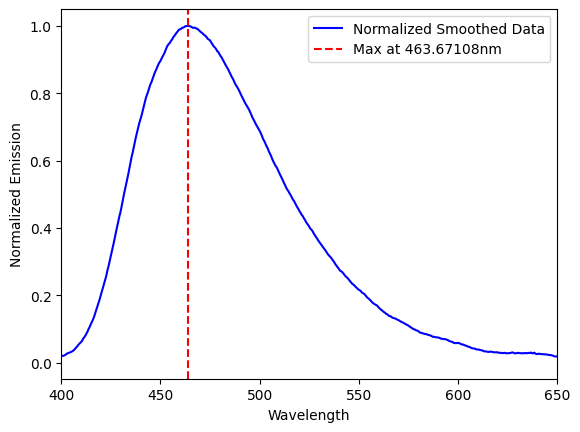

In [21]:
filename = 'June1-Dried Vargula hil 3 animals'
final_data = formatEmission(
    emissionFile=filename+'.asc',
    backgroundFile=background,
    fcol=1, #number of data columns to use in emission and background
    lcol=9,
    calibrationFile=calibration,
    plot=True,
    verbose=False
)
max = sgMaxPlot(final_data, 1,23)  #plot the data with numbers being params of SG smoothing

In [22]:
#add_row(country, species, source, preservation, sex, substrate, biorep, techrep, lmax, fwhm)
add_row(country, species, source, preservation, sex, 'none', filename, 1, max[0], max[1])
alldata


,country,species,source,preservation,sex,substrate,biorep,techrep,lmax,fwhm
0,Japan,Vargula hilgendorfii,purchased,dried,unknown,none,June1-Dried Vargula hil 3 animals,1,463.67108,83.59279


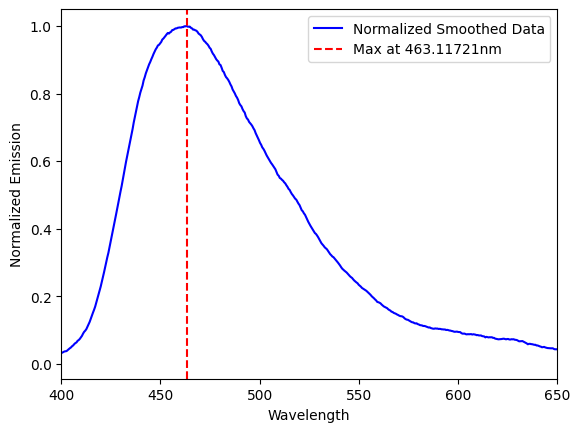

In [23]:
filename = 'June1-Dried Vargula hil 3 animals 2nd trial'
final_data = formatEmission(
    emissionFile=filename+'.asc',
    backgroundFile=background,
    fcol=14, #number of data columns to use in emission and background
    lcol=17,
    calibrationFile=calibration,
    plot=True,
    verbose=False
)
max = sgMaxPlot(final_data, 1,23)  #plot the data with numbers being params of SG smoothing

In [24]:
#add_row(country, species, source, preservation, sex, substrate, biorep, techrep, lmax, fwhm)
add_row(country, species, source, preservation, sex, 'none', filename, 1, max[0], max[1])
alldata


,country,species,source,preservation,sex,substrate,biorep,techrep,lmax,fwhm
0,Japan,Vargula hilgendorfii,purchased,dried,unknown,none,June1-Dried Vargula hil 3 animals,1,463.67108,83.59279
1,Japan,Vargula hilgendorfii,purchased,dried,unknown,none,June1-Dried Vargula hil 3 animals 2nd trial,1,463.11721,86.91653


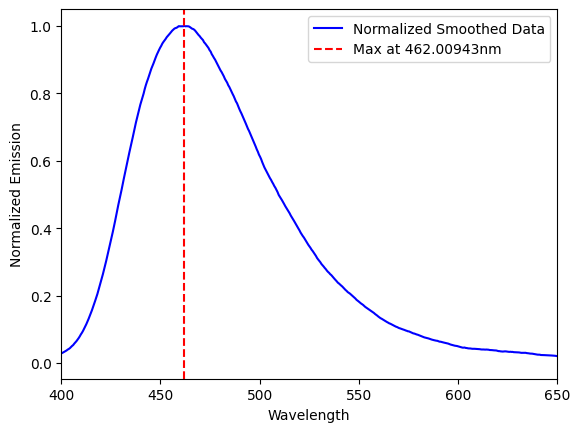

In [25]:
filename = 'June1-hilgen x hilgen cross reactivity'
final_data = formatEmission(
    emissionFile=filename+'.asc',
    backgroundFile=background,
    fcol=1, #number of data columns to use in emission and background
    lcol=4,
    calibrationFile=calibration,
    plot=True,
    verbose=False
)
max = sgMaxPlot(final_data, 1,23)  #plot the data with numbers being params of SG smoothing

In [26]:
#add_row(country, species, source, preservation, sex, substrate, biorep, techrep, lmax, fwhm)
add_row(country, species, source, preservation, sex, 'crude hilgendorfii', filename, 1, max[0], max[1])
alldata

,country,species,source,preservation,sex,substrate,biorep,techrep,lmax,fwhm
0,Japan,Vargula hilgendorfii,purchased,dried,unknown,none,June1-Dried Vargula hil 3 animals,1,463.67108,83.59279
1,Japan,Vargula hilgendorfii,purchased,dried,unknown,none,June1-Dried Vargula hil 3 animals 2nd trial,1,463.11721,86.91653
2,Japan,Vargula hilgendorfii,purchased,dried,unknown,crude hilgendorfii,June1-hilgen x hilgen cross reactivity,1,462.00943,79.17896


## Analyze Dried Cypridina sp from Panama that looked purple when crushed on glass

In [43]:
#For metadata
country = "Panama"
species = "Cypridina sp purple"
source = "collected"
preservation = "dried"
sex = "unknown"

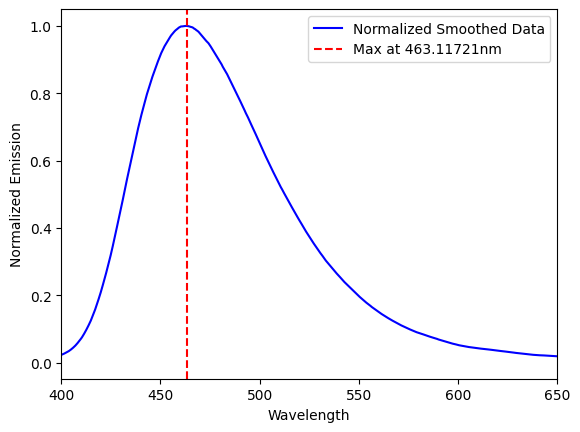

In [31]:
filename = 'June1 - Panama luc and Vhilg extract'
final_data = formatEmission(
    emissionFile=filename + '.asc',
    backgroundFile='June1-water-background.asc',
    fcol=10, #number of data columns to use in emission and background
    lcol=20,
    calibrationFile='PL correction factor 053123.txt',
    plot=True,
    verbose=False
)
max = sgMaxPlot(final_data, 1,23)  #plot the data with numbers being params of SG smoothing

In [29]:
#add_row(country, species, source, preservation, sex, substrate, biorep, techrep, lmax, fwhm)
add_row(country, species, source, preservation, sex, 'crude hilgendrofii', filename, 1, max[0], max[1])
alldata


,country,species,source,preservation,sex,substrate,biorep,techrep,lmax,fwhm
3,Panama,Cypridina sp purple,collected,dried,unknown,crude hilgendrofii,June1 - Panama luc and Vhilg extract,1,463.11721,80.83032
0,Japan,Vargula hilgendorfii,purchased,dried,unknown,none,June1-Dried Vargula hil 3 animals,1,463.67108,83.59279
1,Japan,Vargula hilgendorfii,purchased,dried,unknown,none,June1-Dried Vargula hil 3 animals 2nd trial,1,463.11721,86.91653
2,Japan,Vargula hilgendorfii,purchased,dried,unknown,crude hilgendorfii,June1-hilgen x hilgen cross reactivity,1,462.00943,79.17896


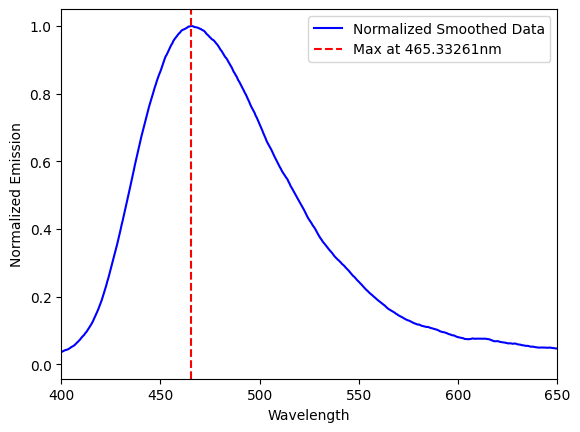

In [42]:
filename = 'June1 - Panama sp 5 animals 3rdtech rep'  #No signal  max values around 800
filename = 'June1 - Panama sp 5 animals 2nd tech rep' #No signal  max values around 800
filename = 'June1 Panama attempt not visible'         #No signal  max values around 800
filename = 'June1-Panama luc 2 and hilgen extract one animal'

final_data = formatEmission(
    emissionFile=filename + '.asc',
    backgroundFile='June1-water-background.asc',
    fcol=1, #number of data columns to use in emission and background
    lcol=20,
    calibrationFile='PL correction factor 053123.txt',
    plot=True,
    verbose=False
)
max = sgMaxPlot(final_data, 1,18)  #plot the data with numbers being params of SG smoothing

In [44]:
#add_row(country, species, source, preservation, sex, substrate, biorep, techrep, lmax, fwhm)
add_row(country, species, source, preservation, sex, 'crude hilgendrofii', filename, 1, max[0], max[1])
alldata


,country,species,source,preservation,sex,substrate,biorep,techrep,lmax,fwhm
0,Panama,Cypridina sp purple,collected,dried,unknown,crude hilgendrofii,June1 - Panama luc and Vhilg extract,1,463.11721,80.83032
4,Panama,Cypridina sp purple,collected,dried,unknown,crude hilgendrofii,June1-Panama luc 2 and hilgen extract one animal,1,465.33261,84.13621
1,Japan,Vargula hilgendorfii,purchased,dried,unknown,none,June1-Dried Vargula hil 3 animals,1,463.67108,83.59279
2,Japan,Vargula hilgendorfii,purchased,dried,unknown,none,June1-Dried Vargula hil 3 animals 2nd trial,1,463.11721,86.91653
3,Japan,Vargula hilgendorfii,purchased,dried,unknown,crude hilgendorfii,June1-hilgen x hilgen cross reactivity,1,462.00943,79.17896
